# Empirical hardness analysis

`````{margin}
````{dropdown} Necessary imports
```{code-block} python
import numpy as np

from colosseum.hardness.analysis import HardnessAnalysisParams, run_scenario_analysis
from colosseum.mdp import BaseMDP
from colosseum.mdp.simple_grid import SimpleGridContinuous

np.random.seed(42)
```
````
`````

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np

from colosseum.hardness.analysis import HardnessAnalysisParams, run_scenario_analysis
from colosseum.mdp import BaseMDP
from colosseum.mdp.simple_grid import SimpleGridContinuous

np.random.seed(42)

Measuring and understanding the hardness of MDPs represent a fundamental step in the development of a {{rl}} benchmark.
This tutorial introduces the hardness measures available in {{col}} and illustrates how to carry out the empirical analysis presented in the paper for the measures available in the package and for custom ones.

<h4> Measures of hardness </h4>

The three efficiently computable theoretical measures of hardness available are the diameter, the environmental value norm, and the {{subgaps}}.
Their code names can be obtained from the 
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.get_available_hardness_measures">``get_available_hardness_measures``</a> 
function.

There are two ways to compute the measures for a 
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP">``BaseMDP``</a>
object.
You can either call the corresponding properties,
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.diameter">``diameter``</a>,
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.value_norm">``value_norm``</a>, and
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.sum_reciprocals_suboptimality_gaps">``sum_reciprocals_suboptimality_gaps``</a>,
or alternatively you can use the
<a href="../pdoc_files/colosseum/mdp/base.html#BaseMDP.get_measure_from_name">``get_measure_from_name``</a>
function, which takes the code name of the measure as input.

In [2]:
mdp = SimpleGridContinuous(seed=0, size=4, p_rand=0.01, n_starting_states=3)

In [3]:
mdp.diameter

6.0545096

In [4]:
print(f"Diameter: {mdp.diameter:.2f}")

Diameter: 6.05


In [5]:
mdp.value_norm

0.49540126

In [6]:
print(f"Environmental value norm: {mdp.value_norm:.2f}")

Environmental value norm: 0.50


In [7]:
mdp.sum_reciprocals_suboptimality_gaps

361.29538

In [8]:
print(f"Sum of the reciprocals of the suboptimality gaps: {mdp.sum_reciprocals_suboptimality_gaps:.2f}")

Sum of the reciprocals of the suboptimality gaps: 361.30


Or alternatively,

In [9]:
mdp = SimpleGridContinuous(seed=0, size=4, p_rand=0.01, n_starting_states=3)
for measure_name in BaseMDP.get_available_hardness_measures():
    print(f"{measure_name}: {mdp.get_measure_from_name(measure_name):.2f}")

diameter: 6.05
value_norm: 0.50
suboptimal_gaps: 361.30


<h4> Hardness scenarios </h4>

The accompanying {{paper}} proposes four scenarios to analyse the two different types of identified complexities: the _visitation complexity_, which relates to the difficulty of visiting all the states, and the _estimation complexity_, which relates to the discrepancy between the optimal policy and the best policy an agent can derive from a given estimate of the transition and reward kernels.

To define a scenario, we create a
[``HardnessAnalysisParams``](../pdoc_files/colosseum/hardness/analysis.html#HardnessAnalysisParams)
object, which encodes the configurations for the scenario.
The [``run_scenario_analysis``](../pdoc_files/colosseum/hardness/analysis.html#run_scenario_analysis) function runs a `HardnessAnalysisParams` and produces the corresponding figure.

Note the ``run_scenario_analysis`` is built on top of the [``get_varying_parameter_dfs``](../pdoc_files/colosseum/hardness/analysis.html#get_varying_parameter_dfs), which computes the hardness measures for the MDP instances.
If multiprocessing is enabled ``get_varying_parameter_dfs`` will use multiple cores.

The [``SimpleGridContinuous``](../pdoc_files/colosseum/mdp/simple_grid/base.html#SimpleGridContinuous) class is used as a running example for the tutorial.

**Scenario 1**  
We vary the probability ``p_rand`` that an MDP executes a random action instead of the action selected by an agent. As ``p_rand`` approaches one, value estimation becomes easier, since outcomes depend less on agent choices. However, intentionally visiting states becomes harder.

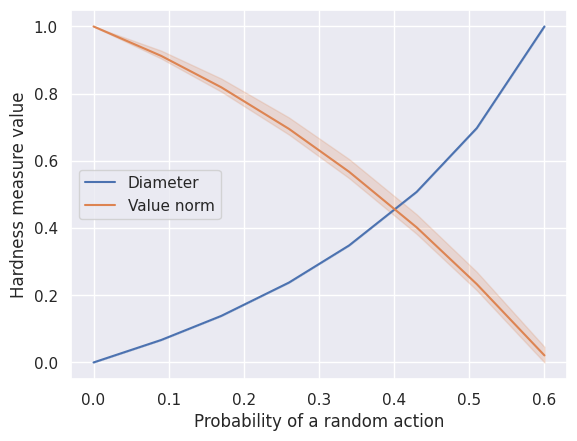

In [10]:
SCENARIO_1_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="p_rand",
    varying_params_name_clean="Probability of a random action",
    varying_params_values=np.linspace(0.0001, 0.6, 8).round(2),
    fixed_params=dict(make_reward_stochastic=True, size=8, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_1_SimpleGridContinuous)

**Scenario 2**  
We vary the probability ``p_lazy`` that an MDP stays in the same state instead of executing
the action selected by an agent. Contrary to increasing p_rand, increasing ``p_lazy`` never benefits
exploration. Increasing ``p_lazy`` decreases estimation complexity and increases visitation complexity.

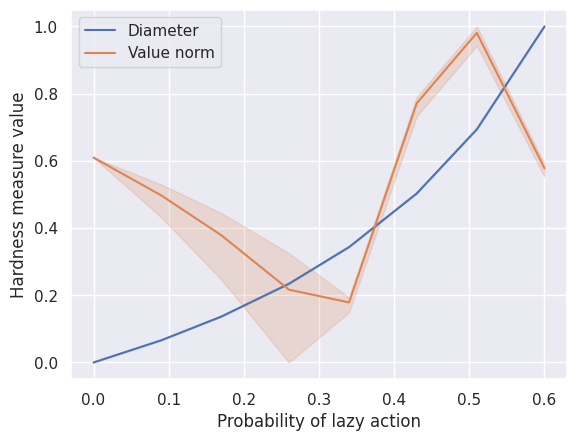

In [11]:
SCENARIO_2_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="p_lazy",
    varying_params_name_clean="Probability of lazy action",
    varying_params_values=np.linspace(0.0001, 0.6, 8).round(2),
    fixed_params=dict(make_reward_stochastic=True, size=8, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_2_SimpleGridContinuous)

**Scenario 3**  
We vary the number of states across MDPs from the same family. Increasing the number of states simultaneously increases the estimation complexity and the visitation complexity.

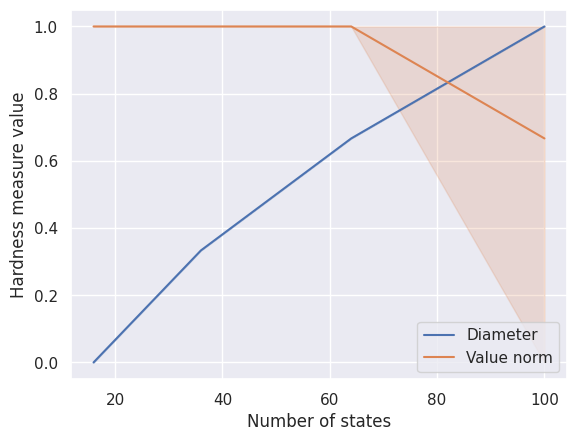

In [12]:
SCENARIO_3_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="size",
    varying_params_name_clean="Number of states",
    varying_params_values=np.arange(4, 12, 2),
    fixed_params=dict(make_reward_stochastic=True, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_3_SimpleGridContinuous)

**Scenario 4**  
We vary the number of states across MDPs from the same family with a fixed value of ``p_rand = 0.1``. Increasing the number of states simultaneously increases the estimation complexity and the visitation complexity.

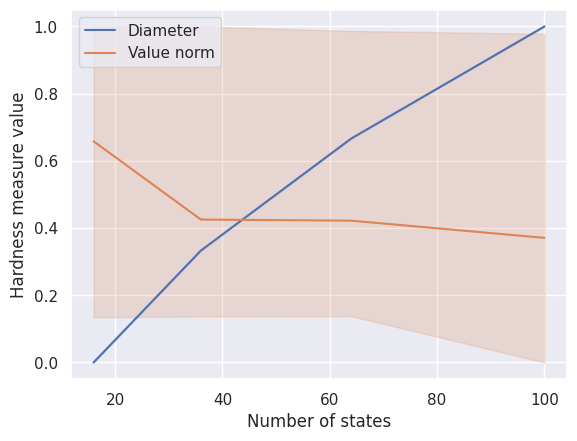

In [13]:
SCENARIO_4_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="size",
    varying_params_name_clean="Number of states",
    varying_params_values=np.arange(4, 12, 2),
    fixed_params=dict(make_reward_stochastic=True, p_rand=0.1, n_starting_states=3),
    n_seeds_mdp=3,
)

run_scenario_analysis(SCENARIO_4_SimpleGridContinuous)

**Custom scenario**  
Running custom scenarios with custom measures of hardness is straightforward since it is possible to specify custom measures of hardness in the ``HardnessAnalysisParams`` configuration.

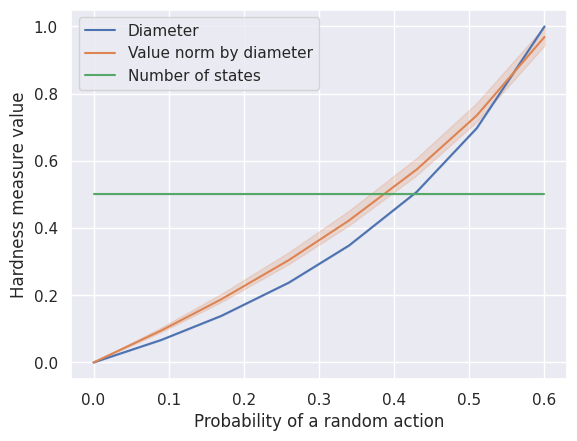

In [14]:
def number_of_states(mdp: BaseMDP) -> float:
    """
    A trivial measure of hardness that simply counts the number of states.
    """
    return mdp.n_states

def value_norm_by_diameter(mdp: BaseMDP) -> float:
    """
    A measure of hardness obtained by multiplying the diameter by the environmental value norm.
    """
    return mdp.diameter * mdp.value_norm
    
custom_scenario_SimpleGridContinuous = HardnessAnalysisParams(
    mdp_class=SimpleGridContinuous,
    varying_params_name="p_rand",
    varying_params_name_clean="Probability of a random action",
    varying_params_values=np.linspace(0.0001, 0.6, 8).round(2),
    fixed_params=dict(make_reward_stochastic=True, size=8, n_starting_states=3),
    hardness_measures=("diameter", value_norm_by_diameter, number_of_states),
    n_seeds_mdp=3,
)

run_scenario_analysis(custom_scenario_SimpleGridContinuous)

In [15]:
import shutil
shutil.rmtree("tmp", ignore_errors=True)
shutil.rmtree("cached_hardness_measures", ignore_errors=True)
shutil.rmtree("tutorial", ignore_errors=True)